In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

In [3]:
import lcpfn 
import torch 
import torch as th
import json
import os
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def readDatasetJson(path):
    f = open(path)

    dataset = json.load(f)
    # print(len(dataset))
    
    x = []
    y = []

    for v in dataset.values():
        x.append(v[0])
        y.append(v[1])
        
    x_true = th.Tensor(x)
    y_true = th.Tensor(y)
    
    return x_true, y_true

def find_file(root_dir, target_filename):
    for root, dirs, files in os.walk(root_dir):
        if target_filename in files:
            return os.path.join(root, target_filename)
    
    # If the loop completes without returning, the file was not found
    return None

def find_data():
    return find_file(os.getcwd(), 'data.json')

def get_data():
    return readDatasetJson(find_data())

def get_test_batch(
    batch_size,
    num_features = 1,
    seq_len = 26,
    device = "cpu",
):
    assert num_features == 1

    x_data, y_data = get_data()
   
    x_data = x_data[3302-batch_size:, :]
    y_data = y_data[3302-batch_size:, :]
    
    y_data_noisy = y_data.clone()
    
    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

def get_random(num_features=1, seq_len=26, device='cpu'):
    assert num_features == 1
    x_data, y_data = get_data()
    ind = np.random.randint(0, 3302)
    x_data = x_data[ind, :]
    y_data = y_data[ind, :]

    print(x_data.shape)
    print(y_data.shape)

    # x_data = x_data.view((num_features, 1, seq_len)).transpose(2, 0).to(device)
    # y_data = y_data.transpose(1, 0).to(device)
    return x_data, y_data

def get_batch(
    batch_size,
    seq_len,
    num_features,
    device="cpu",
    noisy_target=True,
    **_,
):
    assert num_features == 1

    x_data, y_data = get_data()
    print(x_data.shape)
    x_data = x_data[:batch_size, :]
    y_data = y_data[:batch_size, :]

    y_data_noisy = y_data.clone()

    x_data = x_data.view((num_features, batch_size, seq_len)).transpose(2, 0).to(device)
    y_data = y_data.transpose(1, 0).to(device)
    y_data_noisy = y_data.clone()

    return x_data, y_data, y_data_noisy

## Load trained LC-PFN model

In [5]:
result = lcpfn.train_lcpfn(get_batch_func=get_batch, 
                         seq_len=26,
                         emsize=256,
                         nlayers=12,
                         lr=0.001,
                         batch_size=1651,
                         epochs=0)

result[2].load_state_dict(th.load("/home/patrik/new/dl/reproducibility/deep-learning-project/notebooks/models/model_1651.pth"))
model = result[2]

model = lcpfn.LCPFN(model)

Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 1651, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x794f24254430>, 'seq_len_maximum': 26, 'device': 'cpu:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
torch.Size([3302, 26])
Style definition: None
Using a Transformer with 6.46 M parameters


## Generate a learning curve from the prior

(0.0, 1.0)

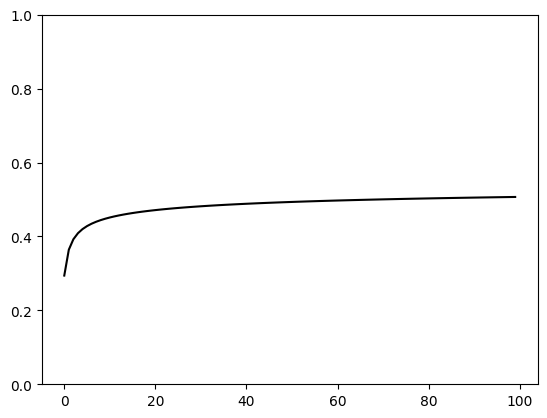

In [6]:
prior = lcpfn.sample_from_prior(np.random)
curve, _ = prior()
plt.plot(curve, "black")
plt.ylim(0, 1)

## Extrapolate the learning curve with a cutoff of 10% 

In [7]:
curve

array([0.2940949 , 0.36415728, 0.39234486, 0.40868396, 0.41977788,
       0.42800771, 0.43446719, 0.43973859, 0.44416456, 0.44796195,
       0.45127581, 0.45420744, 0.45683015, 0.45919854, 0.46135427,
       0.46332977, 0.46515079, 0.46683802, 0.46840838, 0.46987584,
       0.47125206, 0.47254686, 0.47376859, 0.47492443, 0.47602056,
       0.47706233, 0.47805444, 0.47900101, 0.47990568, 0.48077168,
       0.48160189, 0.48239887, 0.48316495, 0.48390221, 0.48461253,
       0.48529761, 0.48595903, 0.48659818, 0.48721638, 0.48781481,
       0.48839457, 0.48895666, 0.48950201, 0.49003148, 0.49054587,
       0.49104593, 0.49153232, 0.49200571, 0.49246668, 0.49291579,
       0.49335358, 0.49378051, 0.49419707, 0.49460367, 0.49500072,
       0.49538862, 0.4957677 , 0.49613833, 0.49650081, 0.49685546,
       0.49720255, 0.49754237, 0.49787517, 0.49820119, 0.49852068,
       0.49883385, 0.49914091, 0.49944207, 0.49973751, 0.50002742,
       0.50031197, 0.50059133, 0.50086567, 0.50113512, 0.50139

In [40]:
# construct 

# x = torch.arange(1, 101).unsqueeze(1)
# y = torch.from_numpy(curve).float().unsqueeze(1)
# cutoff = 10

x, y = get_random()
x = x.squeeze(dim=-1)
cutoff = 13


torch.Size([26])
torch.Size([26])


In [41]:
x.shape

torch.Size([26])

In [42]:
y.shape

torch.Size([26])

In [43]:
#predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

predictions = model.forward(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
predictions = predictions.squeeze(-1)


In [44]:
cutoff

13

In [45]:
y

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9985, 0.9963,
        0.9934, 0.9877, 0.9799, 0.9742, 0.9528, 0.9199, 0.8795, 0.8741, 0.8712,
        0.8660, 0.8441, 0.8425, 0.8094, 0.8077, 0.7874, 0.7788, 0.7763])

In [46]:
pred = predictions.detach().numpy().flatten()
pred

array([1.0012784, 1.0012827, 1.001289 , 1.0012901, 1.0012908, 1.0012919,
       1.001297 , 1.0012974, 1.0013094, 1.0013108, 1.0013264, 1.0013331,
       1.0013349], dtype=float32)

In [47]:
pred.shape

(13,)

In [48]:
xs = x[cutoff:].numpy().flatten()
xs

array([0.1243171 , 0.17579216, 0.2486342 , 0.2635578 , 0.27182057,
       0.2860781 , 0.34721625, 0.35158432, 0.4972684 , 0.51333237,
       0.7050056 , 0.78643036, 0.8098822 ], dtype=float32)

In [49]:
xs.shape

(13,)

In [50]:
x_plot = x.numpy().flatten()

In [51]:
y_plot = y.numpy().flatten()
y_plot

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.999688  , 0.99846   , 0.996256  , 0.993368  ,
       0.987652  , 0.9798862 , 0.9742    , 0.952816  , 0.919916  ,
       0.8795    , 0.87413764, 0.8711687 , 0.86604565, 0.8440775 ,
       0.842508  , 0.809372  , 0.80767095, 0.78737384, 0.77875143,
       0.776268  ], dtype=float32)

(0.0, 1.0013349056243896)

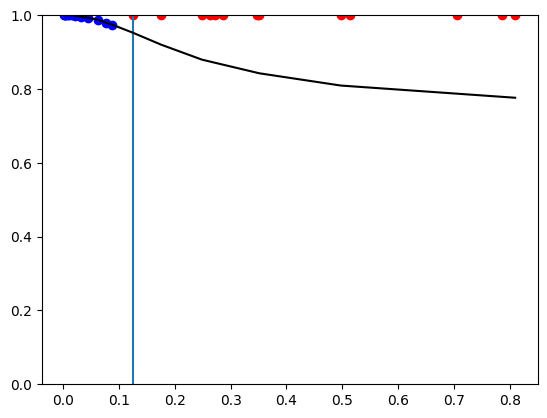

In [52]:
plt.scatter(xs, pred, color='red')
plt.scatter(x[:cutoff], y[:cutoff], color='blue')
plt.axvline(x[cutoff])
plt.plot(x_plot, y_plot, color='black')
plt.ylim([0, max(list(y_plot) + list(pred))])

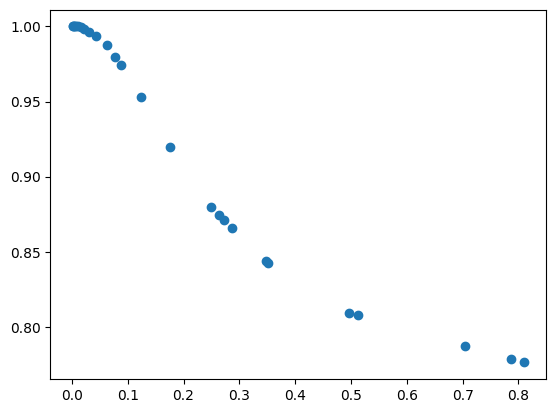

In [53]:
plt.scatter(x_plot, y_plot)